In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gc

# Plot settings
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
sns.set()

## Load card data

In [2]:
# Load card data
# no nulls in test/train except for ONE ROW in test! (first_active_month)
dtypes = {
  'card_id':            'str',     # 201917 unique vals
  'target':             'float32', # -33.22 thru ~18
  'first_active_month': 'str',     # 2011-10 thru 2018-02
  'feature_1':          'uint8',   # 1 thru 5
  'feature_2':          'uint8',   # 1 thru 3
  'feature_3':          'uint8',   # 0 and 1
}
train = pd.read_csv('../input/train.csv',
                    usecols=dtypes.keys(),
                    dtype=dtypes)
del dtypes['target']
test = pd.read_csv('../input/test.csv',
                   usecols=dtypes.keys(),
                   dtype=dtypes)

# Add target col to test
test['target'] = np.nan

# Merge test and train
cards = pd.concat([train, test])

As a quick sanity check, let's make sure there aren't any `card_id`s which are in both test and train:

In [3]:
print('Num unique in train:  ', test['card_id'].nunique())
print('Num unique in test:   ', train['card_id'].nunique())
print('The sum:              ', test['card_id'].nunique()+train['card_id'].nunique())
print('Num unique in merged: ', cards['card_id'].nunique())

Num unique in train:   123623
Num unique in test:    201917
The sum:               325540
Num unique in merged:  325540


OK good, there aren't.  Now we can delete the original dataframes.

In [4]:
del train, test
gc.collect()

7

Let's take a look at the cards data.

In [5]:
cards.sample(10)

,first_active_month,card_id,feature_1,feature_2,feature_3,target
45672,2017-06,C_ID_c1ba850be8,2,2,0,NaN
125999,2017-04,C_ID_3076b8e5c5,1,1,0,-1.524421
61088,2017-08,C_ID_59ba6fc754,5,1,1,NaN
184007,2017-11,C_ID_4d5c728b16,3,3,1,0.182608
112427,2016-07,C_ID_602322506c,3,3,1,-1.403341
91654,2016-03,C_ID_0187985488,3,1,1,NaN
55640,2017-03,C_ID_a9bb18ed02,3,3,1,-1.190091
152504,2017-06,C_ID_5f0783b63e,2,1,0,-2.333803
96763,2013-11,C_ID_ed34b44698,3,3,1,0.689112
154114,2016-04,C_ID_d3aab027fe,3,3,1,-33.219280


The `card_id`s always start with `C_ID_`.  That's kind of a waste of space...  All the `card_id`s are the same length:

In [6]:
cards['card_id'].apply(len).unique()

array([15])

If we cut off the prefix, the remaining strings appear to be all hexidecimal (represented by values 0-9 and a-f):

In [7]:
cards['card_id'].str.slice(5, 15).sample(10)

161707    e03595979b
24953     2f2a8b4c92
59147     d1bba6a319
197310    c1cada56e7
48146     54e85f22a6
55825     bbb251eca0
201859    8ab52d8949
42184     94b6f67728
147310    f6c81447e8
44575     9f0d44d4bd
Name: card_id, dtype: object

We can check that every single entry is indeed a hexideximal:

In [8]:
(cards['card_id']
 .str.slice(5, 15)
 .apply(lambda x: all(e in '0123456789abcdef' for e in x))
 .all())

True

To save space, we could convert the `card_id`s to integers like this:

In [9]:
#cards['card_id'] = cards['card_id'].apply(lambda x: int(x, 16)).astype('uint64')

There are 5 bytes worth of hex info in the card ids, and the values span the full 5-byte range, so we'd have to use a 64-bit integer to represent them (instead of a 32-bit int, which is only 4 bytes).  BUT, there are only 201,917 unique `card_id`s in `train.csv` and 123,623 in `test.csv`, which can easily be represented by a `uint32` (which stores values up to ~4 billion).  The inneficiency of using a 64-bit representation for something where a 32-bit reprentation would do... Bothers me. \*eye twitches\*

To use a 32-bit integer, we'll create a map between the card_id and a unique integer which identifies it, and then map the string values to integer values.  (we need to create a map so that we can map the values in the transactions data in the exact same way)

In [10]:
# Create a map from card_id to unique int
card_id_map = dict(zip(
    cards['card_id'].values,
    cards['card_id'].astype('category').cat.codes.values
))

# Map the values
cards['card_id'] = cards['card_id'].map(card_id_map).astype('uint32')

Now our `card_id`s are 32-bit integers:

In [11]:
cards.sample(10)

,first_active_month,card_id,feature_1,feature_2,feature_3,target
57770,2015-01,131974,3,3,1,NaN
190748,2017-06,64425,2,1,0,0.758280
14635,2017-09,54223,2,1,0,1.334375
22231,2017-10,256128,2,2,0,NaN
15038,2017-08,177212,1,1,0,-0.318805
68618,2017-02,49072,2,1,0,NaN
59575,2015-01,90571,3,3,1,1.119571
104447,2016-03,208318,2,2,0,NaN
154790,2016-01,139315,5,1,1,-3.185444
186714,2017-10,157960,2,2,0,3.766463


Next, we'll convert the `first_active_month` from a string to a datetime.  Unfortunately, there is one.  Single.  Row.  Where `first_active_month` is NaN.

In [12]:
cards[cards['first_active_month'].isnull()]

,first_active_month,card_id,feature_1,feature_2,feature_3,target
11578,NaN,247334,5,2,1,NaN


But other than that row, all the other `first_active_months` are in `YYYY-MM` format:

In [13]:
def nanlen(x):
    if type(x) is float:
        return 'NaN'
    else:
        return len(x)
    
cards['first_active_month'].apply(nanlen).unique()

array([7, 'NaN'], dtype=object)

So, we can convert `first_active_month` column to datetime format.

In [14]:
# Convert first_active_month to datetime
cards['first_active_month'] = pd.to_datetime(cards['first_active_month'],
                                             format='%Y-%m')

Finally, we'll set the index to be the `card_id`.

In [15]:
# Make card_id the index
cards.set_index('card_id', inplace=True)
gc.collect()
cards.sample(10)

,first_active_month,feature_1,feature_2,feature_3,target
card_id,,,,,
139413,2017-01-01,2,1,0,NaN
251061,2017-07-01,5,2,1,0.630939
201606,2017-09-01,3,1,1,NaN
2377,2017-11-01,4,1,0,NaN
186661,2016-06-01,3,2,1,-0.460116
299731,2016-01-01,3,3,1,0.454590
99812,2017-05-01,2,3,0,NaN
312072,2017-10-01,3,1,1,2.028375
228107,2017-01-01,3,2,1,0.356546


## Load Merchants Data

In [16]:
# Datatypes of each column
# (don't load cols which are in transactions data, just use those vals)
# Nulls: NO nulls except for 13 rows in avg_sales_lag{3,6,12}
dtypes = {
  'merchant_id':                 'str',     # 334633 unique values
  'merchant_group_id':           'uint32',  # 1 thru 112586 (w/ some missing, ~109k uniques)
  'numerical_1':                 'float32', # ~ -0.06 thru ~ 183.8 (only 951 unique vals?)
  'numerical_2':                 'float32', # roughly the same as above
  'most_recent_sales_range':     'str',     # A, B, C, D, or E
  'most_recent_purchases_range': 'str',     # A, B, C, D, or E
  'avg_sales_lag3':              'float32', # most between 0 and 2, if you transform by 1/x, all but 3 are between 0 and 4
  'avg_purchases_lag3':          'float32', # most between 0 and 2, if you transform by 1/x, all but 3 are between 0 and 4
  'active_months_lag3':          'uint8',   # 1 to 3 
  'avg_sales_lag6':              'float32', # similar to avg_sales_lag3
  'avg_purchases_lag6':          'float32', # similar to avg_purchases_lag3
  'active_months_lag6':          'uint8',   # 1 to 6
  'avg_sales_lag12':             'float32', # similar to avg_sales_lag3
  'avg_purchases_lag12':         'float32', # similar to avg_purchases_lag3
  'active_months_lag12':         'uint8',   # 1 to 12
  'category_4':                  'str',     # Y or N
}

# Load the data
merchants = pd.read_csv('../input/merchants.csv',
                        usecols=dtypes.keys(),
                        dtype=dtypes)

In [17]:
# Map merchant_id to integer
merch_id_map = dict(zip(
    merchants['merchant_id'].values,
    merchants['merchant_id'].astype('category').cat.codes.values
))

In [18]:
def preprocess_merch_data(df):
    
    # Convert merchant ID to numbers
    df['merchant_id'] = df['merchant_id'].map(merch_id_map).astype('float32')

    # Inverse transforms
    inversions = [
        'avg_sales_lag3',
        'avg_sales_lag6',
        'avg_sales_lag12',
        'avg_purchases_lag3',
        'avg_purchases_lag6',
        'avg_purchases_lag12',
    ]
    for col in inversions:
        df[col] = 1.0/df[col]

    # Encode categorical columns
    bool_map = {'Y': 1, 'N': 0}
    five_map = {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4}
    conversions = [
        ('category_4', bool_map, 'uint8'),
        ('most_recent_sales_range', five_map, 'uint8'),
        ('most_recent_purchases_range', five_map, 'uint8')
    ]
    for col, mapper, new_type in conversions:
        df[col] = df[col].map(mapper).astype(new_type)
        
    # Clean up
    gc.collect()

# Preprocess the merchants data
preprocess_merch_data(merchants)

## Load Transactions Data

In [19]:
# Datatypes of each column
# only NaNs are in category_3, merchant_id, and category_2
dtypes = {
    'authorized_flag':      'str',     # Y or N
    'card_id':              'str',     # 325540 unique values
    'city_id':              'int16',   # -1 then 1 to 347 (is -1 supposed to be nan?)
    'category_1':           'str',     # Y or N
    'installments':         'int8',    # -25, then -1 thru 12 (-1 supposed to be nan?)
    'category_3':           'str',     # A, B, C, and nan (ordinal?)
    'merchant_category_id': 'int16',   # 2 to 891
    'merchant_id':          'str',     # 334633 unique values and nans (164697 nans!)
    'month_lag':            'int8',    # -13 thru 0
    'purchase_amount':      'float32', # min: -0.746, med: -0.699, max: 11269.667
    'purchase_date':        'str',     # YYYY-MM-DD hh:mm:ss
    'category_2':           'float16', # 1 thru 5 and nan (ordinal?)
    'state_id':             'int8',    # -1 then 1 thru 24
    'subsector_id':         'int8'     # 1 thru 41
}

# Load the data
hist_trans = pd.read_csv('../input/historical_transactions.csv', 
                         usecols=dtypes.keys(),
                         dtype=dtypes)
new_trans = pd.read_csv('../input/new_merchant_transactions.csv', 
                        usecols=dtypes.keys(),
                        dtype=dtypes)

# Merge new_merchant_transactions and historical_transactions
trans = pd.concat([hist_trans, new_trans])

# Clean up
del hist_trans, new_trans
gc.collect()

0

We also need to convert the `card_id` to an integer as before, `merchant_id` to an integer in the same way, convert the `purchase_date` column (which has been loaded as a string) to datetime format, and encode the categorical columns.

In [20]:
def preprocess_trans_data(df):
    
    # Convert card_id and merchant_id to numbers
    df['card_id'] = df['card_id'].map(card_id_map).astype('uint32')
    trans['merchant_id'] = trans['merchant_id'].map(merch_id_map).astype('float32')

    # Convert purchase_date to datetime
    trans['purchase_date'] = trans['purchase_date'].str.slice(0, 19)
    trans['purchase_date'] = pd.to_datetime(trans['purchase_date'],
                                            format='%Y-%m-%d %H:%M:%S')

    # Encode categorical columns
    bool_map = {'Y': 1, 'N': 0}
    three_map = {'A': 0, 'B': 1, 'C': 2}
    conversions = [
        ('authorized_flag', bool_map, 'uint8'),
        ('category_1', bool_map, 'uint8'),
        ('category_3', three_map, 'float16'), #has NaNs so have to use float
    ]
    for col, mapper, new_type in conversions:
        trans[col] = trans[col].map(mapper).astype(new_type)
        
    # Clean up
    gc.collect()

# Preprocess the transactions data
preprocess_trans_data(trans)

## Merge merchants with transactions data

In [21]:
# Merge transactions with merchants data
trans = pd.merge(trans, merchants, on='merchant_id')
del merchants
gc.collect()

trans.sample(10)

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id,merchant_group_id,numerical_1,numerical_2,most_recent_sales_range,most_recent_purchases_range,avg_sales_lag3,avg_purchases_lag3,active_months_lag3,avg_sales_lag6,avg_purchases_lag6,active_months_lag6,avg_sales_lag12,avg_purchases_lag12,active_months_lag12,category_4
28119626,1,41500,106,0,0,0.0,705,187952.0,-4,-0.698973,2017-03-08 22:24:22,1.0,9,33,29569,-0.057471,-0.057471,1,1,0.980392,0.989173,3,0.952381,0.970932,6,0.877193,0.934845,12,0
19969372,1,159796,304,0,0,0.0,454,333233.0,-7,-0.737892,2017-07-09 19:24:58,5.0,20,39,12660,-0.057471,-0.057471,3,2,0.980392,0.971284,3,0.892857,0.889462,6,0.840336,0.763042,12,0
28280083,1,250248,140,0,1,1.0,307,62055.0,-13,-0.557544,2017-01-09 15:55:58,1.0,9,19,56759,-0.057471,-0.057471,3,2,1.041667,0.990521,3,1.111111,1.010475,6,0.862069,0.865798,12,0
2113730,1,319812,69,0,1,1.0,879,854.0,-2,-0.713849,2017-12-21 11:29:54,1.0,9,29,35,-0.047556,-0.057471,4,4,0.144300,0.078708,3,0.118765,0.063069,6,0.116686,0.061653,7,1
31343138,1,262117,149,0,1,1.0,68,309162.0,-13,-0.704834,2017-01-11 17:12:49,5.0,20,27,103718,-0.057471,-0.057471,2,3,1.149425,1.105263,3,1.666667,1.425239,6,2.040816,1.551515,12,0
10744689,1,57957,131,0,0,0.0,419,280193.0,-4,-0.703331,2017-10-25 13:49:25,1.0,9,1,35,1.062914,1.062914,2,2,0.934579,0.953029,3,0.819672,0.902125,6,0.819672,0.890451,12,0
30762281,1,107560,268,0,0,0.0,705,95669.0,-1,-0.733384,2018-01-07 11:20:00,5.0,21,33,62667,-0.057471,-0.057471,4,3,1.265823,1.093294,3,1.388889,1.171875,6,1.298701,1.136364,12,0
2949144,0,23237,69,0,1,1.0,755,187955.0,-2,-0.701828,2017-12-08 18:20:39,1.0,9,8,983,0.051593,-0.057471,0,0,0.980392,0.955149,3,1.020408,0.987232,6,1.190476,1.151016,12,1
31223872,1,147589,347,0,1,1.0,705,183080.0,-4,-0.711941,2017-10-11 20:18:14,5.0,20,33,37168,-0.047556,-0.047556,3,3,1.041667,1.006869,3,0.925926,0.896461,6,0.763359,0.812512,12,0
1807637,1,314654,69,0,3,2.0,879,854.0,-2,0.755743,2017-11-08 10:52:39,1.0,9,29,35,-0.057471,-0.057471,0,0,1.075269,1.053421,3,1.162791,1.147823,6,1.315789,1.328655,12,1


## Feature Engineering (for Transactions)

First, let's create some features involving when the transactions occurred.

In [22]:
# Compute features from purchase time/date
tpd = trans['purchase_date']
ref_date = np.datetime64('2017-09-01')
one_hour = np.timedelta64(1, 'h')
trans['purchase_hour'] = tpd.dt.hour.astype('uint8')
trans['purchase_day'] = tpd.dt.dayofweek.astype('uint8')
trans['purchase_week'] = tpd.dt.weekofyear.astype('uint8')
trans['purchase_month'] = tpd.dt.month.astype('uint8')
trans['purchase_weekend'] = (trans['purchase_day'] >=5 ).astype('uint8')
trans['purchase_time'] = ((tpd - ref_date) / one_hour).astype('float32')
trans['ref_date'] = ((tpd - pd.to_timedelta(trans['month_lag'], 'M')
                      - ref_date ) / one_hour).astype('float32')

# TODO: dates relative to first_active_month? (in cards dataset)

# Clean up
del trans['purchase_date']
gc.collect()

56

## Feature Engineering (aggregations from transactions -> cards)

Now we engineer features for each card ID by applying aggregation functions to each card's transactions data.  First we need to group the transactions by `card_id`.

In [23]:
# Group transactions by card id
trans = trans.groupby('card_id', sort=False)

Can we just compute the aggregations and store it in memory?  Shouldn't be that much in theory.  If we store each col as float16s (or similar space for ints), then we should only be using:

In [24]:
# 4 binary aggs (3 new cols each)
# 14 categorical aggs (2 new cols each)
# 18 continuous aggs (7 new cols each)
print(cards.shape[0] * 2*(6 + 4*3 + 14*2 + 18*7), ' Bytes')

111985760  Bytes


112 MB?  Psssh we got this.

First let's define some custom aggregation functions:

In [25]:
def entropy(series):
    """Categorical entropy"""
    probs = series.value_counts().values.astype('float32')
    probs = probs / np.sum(probs)
    probs[probs==0] = np.nan
    return -np.nansum(probs * np.log2(probs))

def mean_diff(series):
    """Mean difference between consecutive items in a series"""
    ss = series.sort_values()
    return (ss - ss.shift()).mean()

def mode(series):
    """Most common element in a series"""
    return series.mode()[0]

And then we can perform the aggregations.

In [26]:
#%pdb on

# Aggregations to perform for each predictor type
binary_aggs = ['sum', 'mean', 'nunique']
categorical_aggs = ['nunique', entropy]
continuous_aggs = ['min', 'max', 'sum', 'mean', 'std', 'skew', mean_diff]

# Aggregations to perform on each column
aggs = {
    'authorized_flag':      binary_aggs,
    'city_id':              categorical_aggs,
    'category_1':           binary_aggs,
    'installments':         continuous_aggs,
    'category_3':           categorical_aggs + ['mean'], #who knows, might be ordinal
    'merchant_category_id': categorical_aggs,
    'merchant_id':          categorical_aggs,
    'month_lag':            continuous_aggs,
    'purchase_amount':      continuous_aggs,
    'purchase_time':        continuous_aggs + ['count'],
    'purchase_hour':        categorical_aggs + [mode],
    'purchase_day':         categorical_aggs + [mode],
    'purchase_week':        categorical_aggs + continuous_aggs + [mode],
    'purchase_month':       categorical_aggs + continuous_aggs + [mode],
    'purchase_weekend':     binary_aggs,
    'ref_date':             continuous_aggs,
    'category_2':           categorical_aggs + ['mean'], #also might be ordinal
    'state_id':             categorical_aggs,
    'subsector_id':         categorical_aggs,
    'merchant_group_id':    categorical_aggs,
    'numerical_1':          continuous_aggs,
    'numerical_2':          continuous_aggs,
    'most_recent_sales_range':     categorical_aggs, #tho really might be continuous?
    'most_recent_purchases_range': categorical_aggs, #tho really might be continuous?
    'avg_sales_lag3':       continuous_aggs,
    'avg_purchases_lag3':   continuous_aggs,
    'active_months_lag3':   continuous_aggs,
    'avg_sales_lag6':       continuous_aggs,
    'avg_purchases_lag6':   continuous_aggs,
    'active_months_lag6':   continuous_aggs,
    'avg_sales_lag12':      continuous_aggs,
    'avg_purchases_lag12':  continuous_aggs,
    'active_months_lag12':  continuous_aggs,
    'category_4':           binary_aggs,
}

# Perform each aggregation
for col, funcs in aggs.items():
    for func in funcs:
        
        # Get name of aggregation function
        if isinstance(func, str):
            func_str = func
        else:
            func_str = func.__name__
            
        # Name for new column
        new_col = col + '_' + func_str
            
        # Compute this aggregation
        cards[new_col] = trans[col].agg(func).astype('float16')
        
        # TODO: may want to normalize before casting to float16?
        # TODO: tho may have enough space for float32s instead of float16s

In [27]:
cards.info()

<class 'pandas.core.frame.DataFrame'>
UInt64Index: 325540 entries, 186538 to 172900
Columns: 178 entries, first_active_month to category_4_nunique
dtypes: datetime64[ns](1), float16(173), float32(1), uint8(3)
memory usage: 114.6 MB


In [28]:
# Save to feather file
cards.reset_index(inplace=True)
cards.to_feather('card_features.feather')

# Read back in with:
# cards = pd.read_feather('../input/card_features.feather')
# cards.set_index('card_id', inplace=True)
# You can read in the data from another kernel by setting this kernel as a data source:
# https://www.kaggle.com/rtatman/importing-data-from-a-kernel

ArrowNotImplementedError: halffloat

In [29]:
# TODO: historical and new_merchants_transactions separately, tho that gives you ~340 feats...

## Computing Mutual info between features and target

TODO: just use

Instead of computing each possible aggregation into one huge dataframe (which might not fit in memory), let's do one aggregation at a time, compute the mutual information with the target of that aggregation, and then move on to the next one.

First we'll define some custom aggregation functions:

Also, we'll make a dataframe containing only the training data (for which we have the target to compute the mutual information with).

In [30]:
train_cards = cards[cards['target'].notna()].copy()

We also need a function to compute the mutual information between two vectors.  We'll use the mutual information of the quantile-transformed aggregation scores (so outliers don't mess up the mutual information calculation).

In [31]:
def quantile_transform(v, res=101):
    """Quantile-transform a vector to lie between 0 and 1"""
    x = np.linspace(0, 100, res)
    prcs = np.nanpercentile(v, x)
    return np.interp(v, prcs, x/100.0)
    
def mutual_information(xi, yi, res=20):
    """Compute the mutual information between two vectors"""
    ix = ~(np.isnan(xi) | np.isinf(xi) | np.isnan(yi) | np.isinf(yi))
    x = xi[ix]
    y = yi[ix]
    N, xe, ye = np.histogram2d(x, y, res)
    Nx, _ = np.histogram(x, xe)
    Ny, _ = np.histogram(y, ye)
    N = N / len(x) #normalize
    Nx = Nx / len(x)
    Ny = Ny / len(y)
    Ni = np.outer(Nx, Ny)
    Ni[Ni == 0] = np.nan
    N[N == 0] = np.nan
    return np.nansum(N * np.log(N / Ni))
    
def q_mut_info(x, y):
    """Compute the mutual information between two quantile-transformed vectors"""
    return mutual_information(quantile_transform(x),
                              quantile_transform(y))

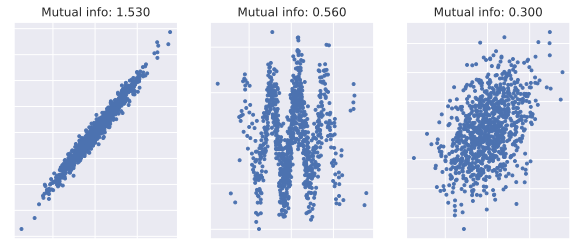

In [32]:
# Show mutual information plots
x = 5*np.random.randn(1000)
y = [x + np.random.randn(1000),
     2*np.sin(x) + np.random.randn(1000),
     x + 10*np.random.randn(1000)]
plt.figure(figsize=(10, 4))
for i in range(3):    
    plt.subplot(1, 3, i+1)
    plt.plot(x, y[i], '.')
    plt.title('Mutual info: %0.3f' % q_mut_info(x, y[i]))
    plt.gca().tick_params(labelbottom=False, labelleft=False)

In [33]:
"""
# Aggregations to perform for each column
# NOTE: to get total # purchases for a cust, count is done on purchase_date
binary_aggs = ['sum', 'mean', 'nunique']
categorical_aggs = ['nunique', entropy]
continuous_aggs = ['min', 'max', 'sum', 'mean', 'std', 'skew', mean_diff]
aggs = {
    'authorized_flag':      binary_aggs,
    'city_id':              categorical_aggs,
    'category_1':           binary_aggs,
    'installments':         continuous_aggs,
    'category_3':           categorical_aggs + ['mean'], #who knows, might be ordinal
    'merchant_category_id': categorical_aggs,
    'merchant_id':          categorical_aggs,
    'month_lag':            continuous_aggs,
    'purchase_amount':      continuous_aggs,
    'purchase_time':        continuous_aggs + ['count'],
    'purchase_hour':        categorical_aggs + ['mode'],
    'purchase_day':         categorical_aggs + ['mode'],
    'purchase_week':        categorical_aggs + continuous_aggs + ['mode'],
    'purchase_month':       categorical_aggs + continuous_aggs + ['mode'],
    'purchase_weekend':     binary_aggs,
    'ref_date':             continuous_aggs,
    'category_2':           categorical_aggs,
    'state_id':             categorical_aggs,
    'subsector_id':         categorical_aggs,
    'merchant_group_id':    categorical_aggs,
    'numerical_1':          continuous_aggs,
    'numerical_2':          continuous_aggs,
    'most_recent_sales_range':     categorical_aggs, #tho really might be continuous?
    'most_recent_purchases_range': categorical_aggs, #tho really might be continuous?
    'avg_sales_lag3':       continuous_aggs,
    'avg_purchases_lag3':   continuous_aggs,
    'active_months_lag3':   continuous_aggs,
    'avg_sales_lag6':       continuous_aggs,
    'avg_purchases_lag6':   continuous_aggs,
    'active_months_lag6':   continuous_aggs,
    'avg_sales_lag12':      continuous_aggs,
    'avg_purchases_lag12':  continuous_aggs,
    'active_months_lag12':  continuous_aggs,
    'category_4':           binary_aggs,
}

# Perform each aggregation and compute MI between the agg and target
mis = []
for col, funcs in aggs.items():
    for func in funcs:
        
        # Get name of aggregation function
        if isinstance(func, str):
            func_str = func
        else:
            func_str = func.__name__
            
        # Compute the mutual information
        train_cards['t_agg'] = trans[col].agg(func)
        mi = q_mut_info(train_cards['target'].values, 
                        train_cards['t_agg'].values)
        mis.append([col, func_str, mi])

# Show mutual information for each aggregation
mi_trans = (pd.DataFrame(mis, columns=['Column', 'Function', 'MutInfo'])
            .sort_values('MutInfo', ascending=False))
print(mi_trans.to_string())
"""

"\n# Aggregations to perform for each column\n# NOTE: to get total # purchases for a cust, count is done on purchase_date\nbinary_aggs = ['sum', 'mean', 'nunique']\ncategorical_aggs = ['nunique', entropy]\ncontinuous_aggs = ['min', 'max', 'sum', 'mean', 'std', 'skew', mean_diff]\naggs = {\n    'authorized_flag':      binary_aggs,\n    'city_id':              categorical_aggs,\n    'category_1':           binary_aggs,\n    'installments':         continuous_aggs,\n    'category_3':           categorical_aggs + ['mean'], #who knows, might be ordinal\n    'merchant_category_id': categorical_aggs,\n    'merchant_id':          categorical_aggs,\n    'month_lag':            continuous_aggs,\n    'purchase_amount':      continuous_aggs,\n    'purchase_time':        continuous_aggs + ['count'],\n    'purchase_hour':        categorical_aggs + ['mode'],\n    'purchase_day':         categorical_aggs + ['mode'],\n    'purchase_week':        categorical_aggs + continuous_aggs + ['mode'],\n    'purc

## Permutation-based feature importance

Run a model using all the features generated, compute permutation-based feature importance, and prune the features used based on that.

In [34]:
# TODO: catboost?